# Multi-Channel EEG modelling with AR

In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

In [2]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/chb01/'

In [3]:
# Summary
# File Name: chb01_03.edf
# File Start Time: 13:43:04
# File End Time: 14:43:04
# Number of Seizures in File: 1
# Seizure Start Time: 2996 seconds
# Seizure End Time: 3036 seconds
raw = mne.io.read_raw_edf(input_fname=os.path.join(root, os.listdir(root)[3]), preload=False, verbose='Error')
ch_names = raw.info['ch_names'] # array of channel names
EEG, times = raw.copy().get_data(picks=['eeg'], units='uV', return_times=True)
seizure_start_time = 2996
seizure_start_index = raw.time_as_index(seizure_start_time)
print(EEG.shape)

(23, 921600)


*Core Feature Extraction Algorithm*

In [4]:
fs = raw.info['sfreq']   # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 3                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = EEG.shape[0]       # Number of EEG electrodes (channels)
m = 30                   # MA parameter

print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')

Input channels: 23
Model: AR(3)
MA lookback: 30
Window size: 512
Sampling frequency: 256.0 Hz
Prediction frequency: 0.5 Hz


In [5]:
%%time
np.random.seed(42)
n_samples = EEG.shape[1]                  # Length of input signal
e = EEG                                   # Feed input signal
a = 1.8 * np.random.randn(n_c, n_i)       # Initialise AR coefficients
c = m*np.ones(m)                          # Initialise MA coefficients
c = c/c.sum()

k = np.zeros(1)
Ik = N                                    # Set window width
ar_index_list = []                        # Sequential buffer of time index
ar_hats_list = []                         # Sequential buffer of AR coefficients (conisder replacing these with vstack)
a_ma_list = []
for t in range(Ik + n_i, n_samples):      # Moving window starting from index 1 to (n_samples-1)
    if (t % N == 0):                      # Decimation policy: a is computed once every N samples
        window_start = t - Ik - n_i + 1
        window_end = t 
        a_hat = np.zeros((n_c, n_i))
        phi = np.zeros((n_c, n_i))
        for i in range(n_c):                          # Iterate electrodes
            x_t = e[i, window_start:window_end]       # Multi-channel window over input signal
            N_window = len(x_t)
            ymat = np.zeros((N_window-n_i, n_i))
            yb = np.zeros((N_window-n_i, n_i))
            for _c in range(n_i, 0, -1):
                ymat[:, n_i-_c] = x_t[n_i-_c:-_c]
            
            yb = x_t[n_i:]
            a_hat[i] = np.linalg.pinv(ymat) @ yb
        
        a_ma = np.zeros((n_c, n_i))
        ar_hats_k = len(ar_hats_list)-1               # Index to most recent block of AR parameters of shape: (n_c, n_i)
        for j in range(m):                            # MA smoothing of AR parameters going back m units of time, in timescale k (+1 ensures it goes up to m)
            if len(ar_hats_list) > m:                 # Only begin smoothing once unit of time passed is greater than m (MA lookback parameter) 
                a_ma = c[j] * ar_hats_list[ar_hats_k-j]
        
        ar_index_list.append(t)                       # Record time index of when a is computed
        ar_hats_list.append(a_hat)
        a_ma_list.append(a_ma)
                        
ar_index = np.array(ar_index_list)
ar_hats = np.array(ar_hats_list)
ars = np.array(a_ma_list)
print('Input dimension:', e.shape)
print('Output dimension:', ar_hats.shape)

Input dimension: (23, 921600)
Output dimension: (1798, 23, 3)
CPU times: user 14.5 s, sys: 492 ms, total: 15 s
Wall time: 10.6 s


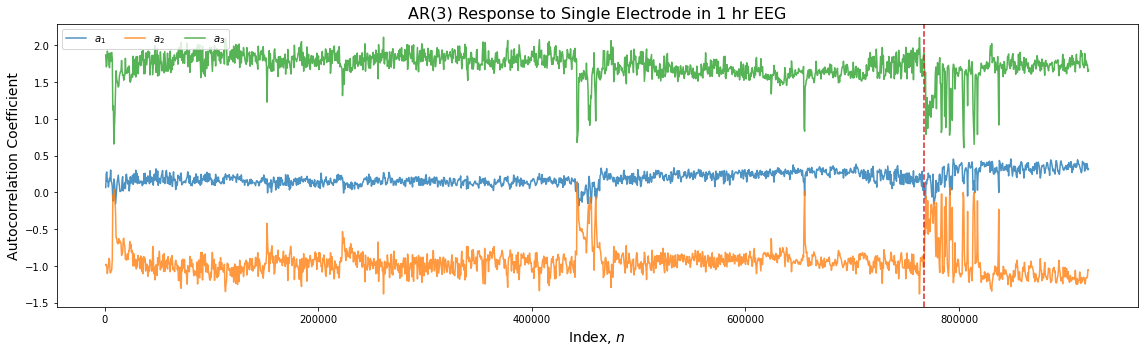

In [6]:
# a_1 = ar_hats[:,0,0]   # select first AR coefficient for 1 channel and for all times

plt.figure(figsize=(16,5))
for i in range(n_i):
    plt.plot(ar_index, ar_hats[:,0,i], label=f'$a_{i+1}$', alpha=0.8)
plt.axvline(x=seizure_start_index, color='tab:red', ls='--')

plt.xlabel(r'Index, $n$', fontsize=14)
plt.ylabel('Autocorrelation Coefficient', fontsize=14)
# plt.ylim([-.5, 1])
plt.legend(loc=2, ncol=8)
plt.title(f'AR({n_i}) Response to Single Electrode in 1 hr EEG', fontsize=16)
plt.tight_layout()
plt.show()

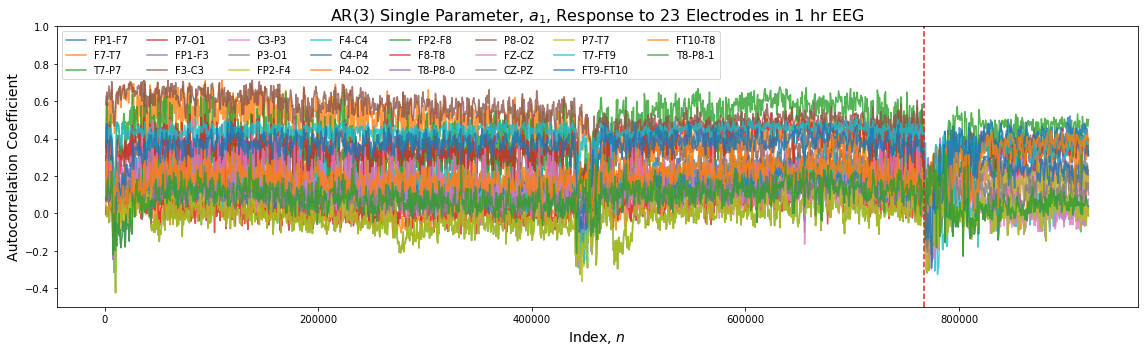

In [7]:
a_1 = ar_hats[:,:,0]   # select first AR coefficient for all channels and for all times

plt.figure(figsize=(16,5))
for i in range(n_c):
    plt.plot(ar_index, a_1[:,i], label=f'{ch_names[i]}', alpha=0.8)
plt.axvline(x=seizure_start_index, color='tab:red', ls='--')
plt.xlabel(r'Index, $n$', fontsize=14)
plt.ylabel('Autocorrelation Coefficient', fontsize=14)
plt.ylim([-.5, 1])
plt.legend(loc=2, ncol=8)
plt.title(f'AR({n_i}) Single Parameter, $a_1$, Response to 23 Electrodes in 1 hr EEG', fontsize=16)
plt.tight_layout()
plt.show()

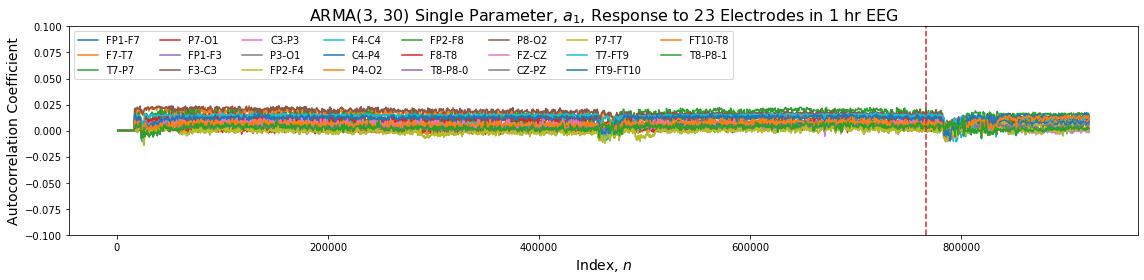

In [8]:
ar_1 = ars[:, :, 0] # select first AR coefficient for all channels and for all times

plt.figure(figsize=(16,4))
for i in range(n_c): # for each electrode
    plt.plot(ar_index, ar_1[:,i], label=f'{ch_names[i]}', )
plt.axvline(x=seizure_start_index, color='tab:red', ls='--')
plt.xlabel(r'Index, $n$', fontsize=14)
plt.ylabel('Autocorrelation Coefficient', fontsize=14)
plt.ylim([-.1, .1])
plt.legend(loc=2, ncol=8)
plt.title(f'ARMA{n_i, m} Single Parameter, $a_1$, Response to 23 Electrodes in 1 hr EEG', fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
'f_{{{0}}}'.format('in')

'f_{in}'

In [29]:
'Hello {0}, your balance is {1}.'.format('Adam', 230)

'Hello Adam, your balance is 230.'

In [33]:
"ARMA({order}, {lag})".format(order=n_i, lag=m)

'ARMA(3, 30)'

In [ ]:
fig, axs = plt.subplots(n_i, 1, figsize=(16, 10), sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .8, wspace=.001)
axs = axs.ravel()
for i in range(n_i): # for each coefficient
    for j in range(n_c): # for each channel
        axs[i].plot(ar_index, ars[:, j, i], label=f'{ch_names[j]}')
        axs[i].set_ylim([-.1, .1])
        axs[i].set_title(f'$a_{i+1}$')
        axs[i].axvline(x=seizure_start_index, color='tab:red', ls='--')
axs[-1].set_xlabel(r'Index, $n$', fontsize=14)
axs[1].set_ylabel('Autocorrelation Coefficient', fontsize=14)
plt.legend(bbox_to_anchor=(1.12, 5.3), ncol=1)
plt.suptitle(r"$ARMA({0}, {1})$ Multi-Parameter, $\bf{{a}}$, Response to 23 Electrodes in 1 hr EEG".format(n_i, m), fontsize=16)
# plt.tight_layout()
plt.show()  
#'ARMA{n_i, m} $\mathbf{a}$ Response to 23 Electrodes in 1 hr EEG'

---

In [12]:
# ars[time, channel, coefficient]
ars[:,0,0].shape

(1798,)

In [13]:
# slice a window across all channels
len(EEG[22, 0:10])
# x = EEG[:, 0:10]
# x[22].shape

10